# Timeseries forcasting with SKforecast

## Installing  the packages

In [33]:
# Data manipulation
# ==============================================================================
import os

# Other utils
# ==============================================================================
import warnings

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Modelling and Forecasting
# ==============================================================================

# Configure plotting and other settings
# ==============================================================================
%matplotlib inline
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')


### Getting the Data 

In [34]:
# Create a new figure
fig = go.Figure()

# Add traces for train, validation, and test datasets
# Specify color using the line=dict(color='color') argument
# fig.add_trace(go.Scatter(x=data_train.index, y=data_train.Demand, mode='lines',
#                        name='train', line=dict(color='blue')))
# fig.add_trace(go.Scatter(x=data_val.index, y=data_val.Demand, mode='lines',
#                        name='validation', line=dict(color='darkorange')))
# fig.add_trace(go.Scatter(x=data_test.index, y=data_test.Demand, mode='lines',
#                         name='test', line=dict(color='darkgreen')))

# Set the title
fig.update_layout(title='Electricity demand',
                  xaxis_title='Time',
                  yaxis_title='Demand',
                  autosize=False,
                  width=900,
                  height=400,
                   margin={
                       'l': 50,
                       'r': 50,
                       'b': 100,
                       't': 100,
                       'pad': 4,
    }
)

# Display the figure
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

* Time: date and time of the record.
* Date: date of the record.
* Demand: electricity demand (MW).
* Temperature: temperature in Melbourne, the capital of Victoria.
* Holiday: indicates if the day is a public holiday.


In [20]:
# Set the file paths
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/' +
       'data/vic_elec.csv')
cache_dir = 'cache'
os.makedirs(cache_dir, exist_ok=True)
local_filename = os.path.join(cache_dir, 'vic_elec.csv')
local_parquet_filename = os.path.join(cache_dir, 'vic_elec.parquet')

# Check if local parquet file exists
if os.path.exists(local_parquet_filename):
    # Load data from local parquet file
    data = pd.read_parquet(local_parquet_filename)
else:
    # Download data and save as local CSV
    if not os.path.exists(local_filename):
        data = pd.read_csv(url)
        data.to_csv(local_filename, index=False)
    else:
        data = pd.read_csv(local_filename)

    # Save data as local parquet file for future runs
    data.to_parquet(local_parquet_filename)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


In [21]:
data = pd.read_parquet("./cache/vic_elec.parquet")
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 8.1 MB


In [22]:
display(data.head(2), data.info(memory_usage="deep", verbose=True, show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 8.1 MB


,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True


None

In [6]:
#data.reset_index()

,index,Time,Demand,Temperature,Date,Holiday
0,0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...,...
52603,52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


In [23]:
data["Time"].dtype

dtype('O')

* The *Time column* is stored as a string.
* To convert it to 'datetime', the function 'pd.to_datetime()' is used.
* Once in datetime format, and to make use of pandas functionalities, it is set as an index. 
* Since the data was recorded every 30 minutes, the frequency ('30min') is also specified.

In [24]:
data = data.copy()
data['Time'] = pd.to_datetime(data['Time'], format='%Y-%m-%dT%H:%M:%SZ')
data = data.set_index('Time')
data = data.asfreq('30min')
data = data.sort_index()
display(data.head(2), data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52608 entries, 2011-12-31 13:00:00 to 2014-12-31 12:30:00
Freq: 30min
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand       52608 non-null  float64
 1   Temperature  52608 non-null  float64
 2   Date         52608 non-null  object 
 3   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(1)
memory usage: 1.7+ MB


,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


None

In [25]:
# Verify that a temporary index is complete
# ==============================================================================
(data.index == pd.date_range(start=data.index.min(),
                              end=data.index.max(),
                              freq=data.index.freq)).all()


True

Yeah no missing indix, no missing dates

### Finding missing values 

Some tools don't like NaN's 

In [26]:
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")

Number of rows with missing values: 0.0


It there might be missing values:

In [36]:
# Fill gaps in a temporary index
# ==============================================================================
#data.asfreq(freq='30min', fill_value=np.nan)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 11:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 11:30:00,3724.835666,17.70,2014-12-31,False


The original data we have is recorded every 30 minutes, but our goal is to make a model that can predict electricity demand on an hourly basis. So, we need to adjust our data to match this hourly format. Thankfully, with the Pandas library's timestamp indexing and its resample() function, this task can be accomplished efficiently.

We should pay close attention to the use of the 'closed' and 'label' parameters in the resample() function to prevent data leakage, which could introduce future information into our model training process. To illustrate, let's consider we have readings at the times: 10:10, 10:30, 10:45, 11:00, 11:12, and 11:30. If we want to calculate an hourly average, the average for 11:00 should only include readings from 10:10, 10:30, and 10:45. The average for 12:00 should be calculated using readings from 11:00, 11:12, and 11:30. This way, we ensure we're not using future information when calculating each hourly average.


The Pandas resample function: can be found [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html)

A more expandet article can be found [here](https://towardsdatascience.com/using-the-pandas-resample-function-a231144194c4)

In [27]:
# Aggregating in 1H intervals
# ==============================================================================
# The Date column is eliminated so that it does not generate an error when aggregating.
# The Holiday column does not generate an error since it is Boolean and is treated as 0-1.
data = data.drop(columns='Date')
data = data.resample(rule='H', closed='left', label ='right').mean()
data

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


The original data range is from 14:00:00 on December 31, 2011, to 13:00:00 on December 31, 2014.
However, to standardize the start and end times, the first 10 entries and the last 13 entries have been removed.
This modification makes the dataset span from 00:00:00 on January 1, 2012, to 23:00:00 on December 30, 2014. Additionally, to fine-tune our model's hyperparameters and assess its predictive performance, the data is split into three subsets: training, validation, and testing.

In [28]:
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}")

Train dates      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00
Validation dates : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00
Test dates       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00


In [29]:
# Create a new figure
fig = go.Figure()

# Add traces for train, validation, and test datasets
# Specify color using the line=dict(color='color') argument
fig.add_trace(go.Scatter(x=data_train.index, y=data_train.Demand, mode='lines',
                         name='train', line={'color':'blue'}))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val.Demand, mode='lines',
                         name='validation', line={'color':'darkorange'}))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test.Demand, mode='lines',
                         name='test', line={'color':'darkgreen'}))

# Set the title
fig.update_layout(
    title='Electricity demand',
    xaxis_title='Time',
    yaxis_title='Demand',
    autosize=False,
    width=900,
    height=400,
    margin={
        'l': 50,
        'r': 50,
        'b': 100,
        't': 100,
        'pad': 4,
    },
)

# Display the figure
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [13]:
def perform_fft(data, column, frequency_range=None):
    # Extract the time series data from the specified column
    time_series = data[column].values

    # Compute the FFT
    fft_values = np.fft.fft(time_series)

    # Compute the corresponding frequencies
    freq = np.fft.fftfreq(len(time_series))

    # Consider only positive frequencies
    positive_freq_mask = freq >= 0
    freq = freq[positive_freq_mask]
    fft_values = fft_values[positive_freq_mask]

    # Zoom in on the desired frequency range if specified
    if frequency_range is not None:
        freq_mask = (freq >= frequency_range[0]) & (freq <= frequency_range[1])
        freq = freq[freq_mask]
        fft_values = fft_values[freq_mask]

    # Calculate periods corresponding to frequencies
    periods = 1 / freq

    # Plot the periods
    plt.figure(figsize=(12, 6))
    plt.plot(periods, np.abs(fft_values))
    plt.xlabel('Log Period')
    plt.xscale('log')
    plt.ylabel('Amplitude')
    plt.title('Frequency Analysis')
    plt.grid(True)
    plt.show()


In [15]:

# Create a new figure
fig = go.Figure()

# Add a trace for the complete dataset
fig.add_trace(go.Scatter(x=data.index,
                        y=data.Demand,
                        mode='lines',
                        name='Demand',
                        line={'color':"black"}))


# Set the title and layout
fig.update_layout(
    title='Electricity demand',
    xaxis_title='Time',
    yaxis_title='Demand',
    autosize=False,
    width=900,
    height=400,
    margin={
        'l': 50,
        'r': 50,
        'b': 100,
        't': 100,
        'pad': 4,
    },
    xaxis={
        'rangeslider': {
            'visible': True,
        },
        'type': 'date',
    },
)

# Display the figure
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

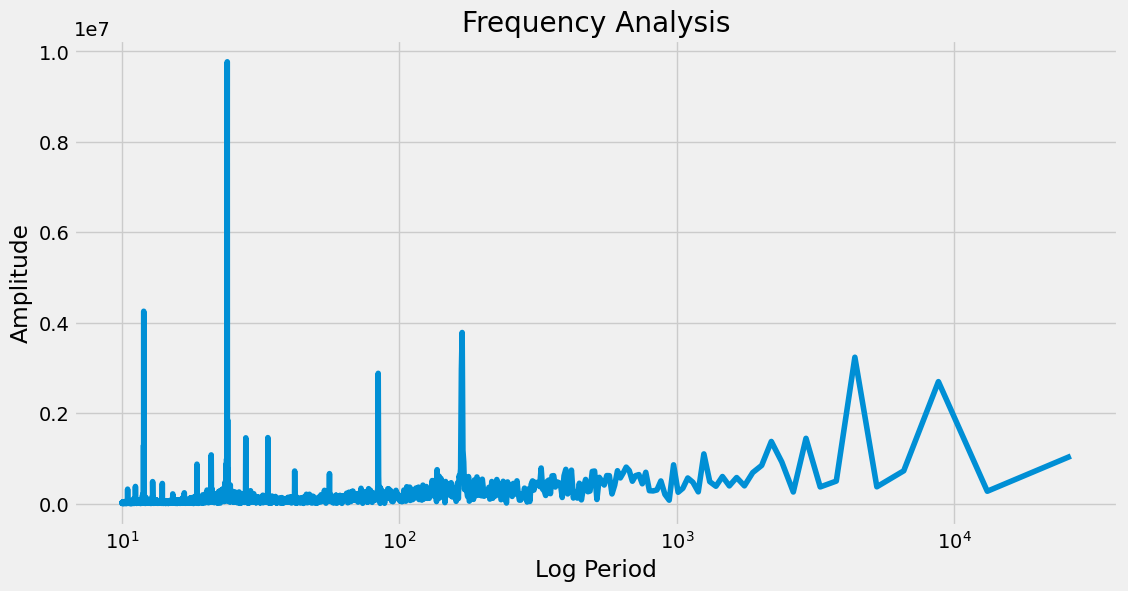

In [16]:
perform_fft(data, 'Demand', frequency_range=(0, 0.1))

In [31]:
fig = px.line()

fig.add_scatter(x=data_train.index, y=data_train['Demand'], name='train', line={'width': 1})
fig.add_scatter(x=data_val.index, y=data_val['Demand'], name='validation', line={'width': 1})
fig.add_scatter(x=data_test.index, y=data_test['Demand'], name='test', line={'width': 1})

fig.update_layout(title='Electricity demand')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

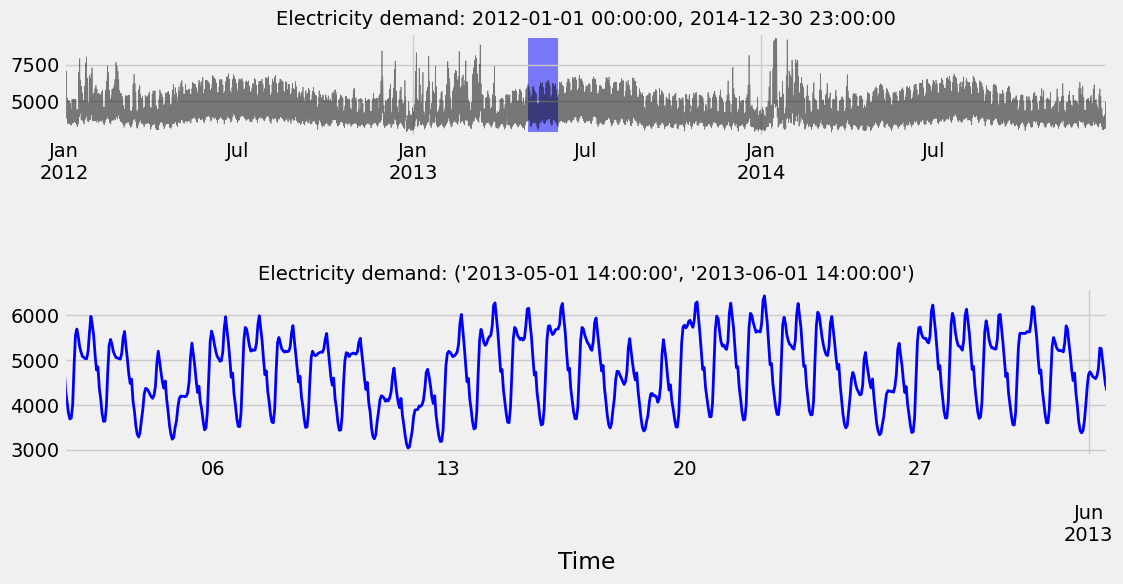

In [30]:
# Zooming time series chart
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

data.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(data.Demand)
max_y = max(data.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

data.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Electricity demand: {data.index.min()}, {data.index.max()}', fontsize=14)
zoom_ax.set_title(f'Electricity demand: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)


In [81]:
import pandas as pd
from common.metrics import nd
from datasets.electricity import ElectricityDataset
from experiments.electricity.main import splits
from summary.electricity import ElectricitySummary
from summary.utils import median_ensemble


def summary(split_name: str, summary_filter: str = '*'):
    training_set, test_set = ElectricityDataset.load().split_by_date(splits[split_name])
    summary = ElectricitySummary(test_set.split(7*24)[0])

    generic = pd.DataFrame(summary.evaluate(median_ensemble('/experiment/storage/experiments/electricity_generic',
                                                             forecast_file=f'forecast_{split_name}.csv',
                                                            summary_filter=summary_filter), metric=nd), index=['generic'])
    interpretable = pd.DataFrame(summary.evaluate(median_ensemble('/experiment/storage/experiments/electricity_interpretable',
                                                             forecast_file=f'forecast_{split_name}.csv',
                                                            summary_filter=summary_filter), metric=nd), index=['interpretable'])
    ensemble = pd.DataFrame(summary.evaluate(median_ensemble('/experiment/storage/experiments/electricity_*',
                                                             forecast_file=f'forecast_{split_name}.csv',
                                                            summary_filter=summary_filter), metric=nd), index=['ensemble'])
    return pd.concat([generic, interpretable, ensemble])


ModuleNotFoundError: No module named 'common.metrics'